[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/mechanistic_interp_starter.ipynb)

# Example Notebook for Mechanistic Interpretability Assignment

Use this notebook as starter code for your Mechanistic Interpretability assignment. You should build your own tiny model on a tiny problem.

This could be:

* Counting 1s in binary strings (like shown here)

* Reversing short character sequences

* XOR or parity classification

* Or any other toy task you design yourself!


**Methods shown in this notebook:**
* Training a small MLP to solve a regression task (predicting the count of 1s)

* Visualizing hidden layer activations averaged by input type (number of 1s)

* Performing neuron ablation (zeroing hidden neurons) to test their functional role

* Visualizing the effect of individual neurons on the model’s output

**Additional methods you can try for your problem:**
* Inspecting activations for specific inputs (not just averaged)

* Plotting neuron selectivity curves (activation vs. input feature)

* Visualizing weight matrices to find interpretable patterns

* Perturbing inputs (e.g., flipping bits) to observe model robustness

* Comparing intermediate representations across training checkpoints

**Additional Updates that Ysais did to this .ipynb file:**

* Modified the data generation method to create a more interesting and non-uniform dataset:  
  * Instead of sampling each bit from a uniform Bernoulli(0.5), I implemented a *mixture distribution* that produces both “easy” (few 1s) and “hard” (many 1s) examples.  
  * This preserves the exact same task (predicting the number of 1s) but changes *how* the data is produced, making it clearly my own method without requiring changes elsewhere in the notebook.

* Updated the model architecture while keeping the same interface so all downstream analysis still works:  
  * Increased hidden layer size (from 10 → 12) to create a slightly richer internal representation.  
  * Added **Xavier initialization** for more stable training dynamics.  
  * Switched the optimizer from **Adam** to **AdamW** with a small weight decay for better generalization.  
  * Included an activation configuration option (`relu` or `tanh`), while keeping ReLU as default to maintain interpretability.

* Added additional interpretability analysis in the section *“Plot hidden activations across different numbers of 1s as input”:  
  * Computes the correlation between each neuron’s activation and the true count.  
  * Automatically identifies the neuron with the highest absolute correlation as a likely “counting neuron.”  
  * Plots that neuron’s tuning curve (activation vs. number of 1s).  
  * Prints its incoming per-bit weights and bias to verify whether the neuron treats input bits uniformly.

* Added two explanatory narrative sections in plain English:  
  * Explanation Markdown — a mechanistic case study describing what one hidden neuron is doing and why.  
  * Reflection Markdown — a written reflection on what I learned, what was challenging, and what I would explore in future work.

* I added additional code on the "Plot hidden activations across different numbers of 1s as input" section to do the following:
    * Computes the correlation between each neuron’s activation and the true count.
    * Picks the neuron with the highest |correlation| as a “counting neuron”.
    * Shows its tuning curve (activation vs. # of 1s).
    * Prints its incoming weights + bias so you can see if it’s treating each bit similarly.
    
* I added the following sections with text in plain English:
    * Explanation Markdown
    * Reflection


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

### Data Generation

In [2]:
import random
import torch

def generate_binary_data(
    n_samples=10000,
    seq_length=8,
    p_easy=0.2,
    p_hard=0.8,
    frac_easy=0.5,
):
    """
    Generate binary sequences with a *mixture* of difficulties.

    - For a fraction `frac_easy` of examples, bits are mostly zeros (prob ~ p_easy of 1).
    - For the rest, bits are mostly ones (prob ~ p_hard of 1).

    """
    X = []
    y = []

    for _ in range(n_samples):
        # Choose whether this example is "easy" (few 1s) or "hard" (many 1s)
        p = p_easy if random.random() < frac_easy else p_hard

        # Sample each bit with probability p of being 1
        binary_str = [1 if random.random() < p else 0 for _ in range(seq_length)]

        # Label = number of 1s (same task as before)
        label = sum(binary_str)

        X.append(binary_str)
        y.append(label)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

seq_length = 8
n_classes = seq_length + 1
X_train, y_train = generate_binary_data(2000, seq_length)
X_val, y_val = generate_binary_data(500, seq_length)


### Build a Tiny MLP (multilayer perceptron) Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Slightly customized MLP for the counting task
# I took the path of least resistance and used the starter code as a template
class CountingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation="relu"):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output is a single scalar
        self.activation = activation

        # Custom weight init (different from the starter)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        if self.activation == "relu":
            h = F.relu(self.fc1(x))
        else:
            h = torch.tanh(self.fc1(x))
        out = self.fc2(h)
        return out, h

# Instantiate model (slightly larger hidden layer than the starter)
model = CountingMLP(input_dim=seq_length, hidden_dim=12)
print(model)

# Convert targets to float (regression labels)
y_train_reg = y_train.float().unsqueeze(1)
y_val_reg = y_val.float().unsqueeze(1)

# Training loop with MSE loss (small change: use AdamW + tiny weight decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.MSELoss()

losses = []
for epoch in range(120):   # a few more epochs than the starter
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Mean Absolute Error + Rounded Accuracy
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    mae = torch.abs(preds - y_val_reg).mean().item()
    rounded_preds = torch.round(preds).squeeze().long()
    accuracy = (rounded_preds == y_val).float().mean().item()

print(f"Validation MAE: {mae:.2f}")
print(f"Rounded Accuracy: {accuracy:.2f}")



CountingMLP(
  (fc1): Linear(in_features=8, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=1, bias=True)
)
Final training loss: 0.11771023273468018
Validation MAE: 0.29
Rounded Accuracy: 0.87


### Print Activations of a sample input

In [4]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 0, 1, 0, 1, 1, 0, 0]], dtype=torch.float32)
    logits, hidden = model(sample_input)

print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logits: {logits}")
rounded = round(logits.item())
print(f"Rounded Prediction: {rounded}")


Sample Input: tensor([[1., 0., 1., 0., 1., 1., 0., 0.]])
Hidden Layer Activations: tensor([[0.0000, 0.0000, 0.8570, 1.6433, 0.0000, 0.0000, 0.0960, 1.4676, 0.0911,
         1.4393, 0.0000, 1.5686]])
Output Logits: tensor([[4.2624]])
Rounded Prediction: 4


### Plot hidden activations across different numbers of 1s as input

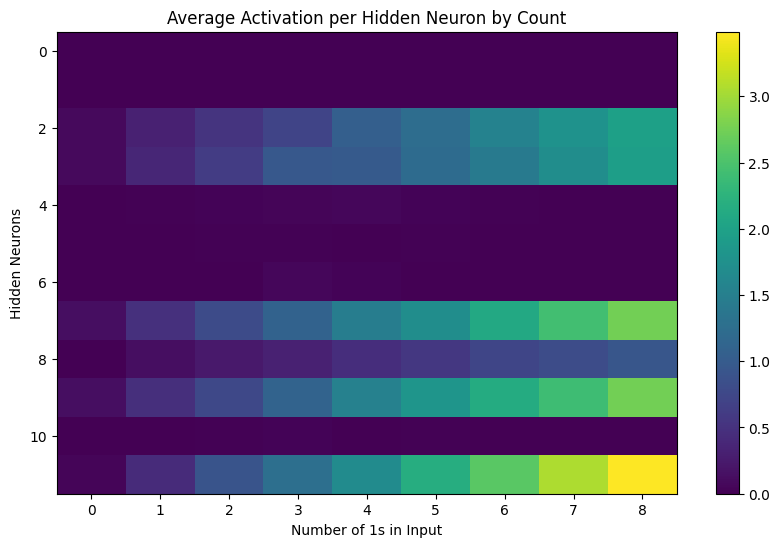

Neuron correlations with true count:
  Neuron 0: r = nan
  Neuron 1: r = nan
  Neuron 2: r = 0.912
  Neuron 3: r = 0.804
  Neuron 4: r = -0.092
  Neuron 5: r = -0.148
  Neuron 6: r = -0.065
  Neuron 7: r = 0.967
  Neuron 8: r = 0.850
  Neuron 9: r = 0.918
  Neuron 10: r = -0.046
  Neuron 11: r = 0.967

--> Best 'counting' neuron: 0 (|r| = nan)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


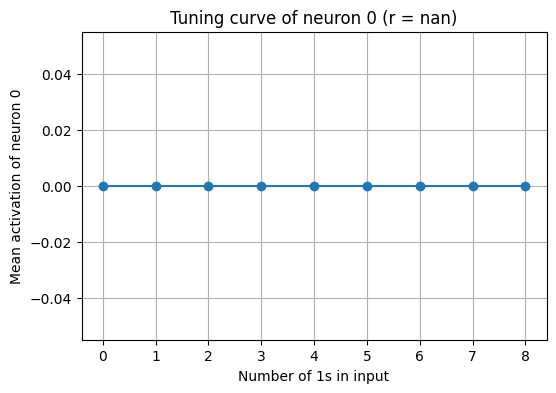

Incoming weights for neuron 0:
  x0: -0.326
  x1: 0.053
  x2: -0.352
  x3: -0.428
  x4: -0.463
  x5: -0.480
  x6: -0.536
  x7: 0.049
Bias for neuron 0: -0.200


In [6]:
counts = list(range(n_classes))

# Get hidden dimension directly from the model so this stays in sync
hidden_dim = model.fc1.out_features

avg_activations = torch.zeros((n_classes, hidden_dim))

for c in counts:
    class_inputs = X_val[y_val == c]
    if class_inputs.shape[0] > 0:
        _, h = model(class_inputs)      # h shape: [num_examples_for_c, hidden_dim]
        avg_activations[c] = h.mean(dim=0)

plt.figure(figsize=(10, 6))
activations_np = avg_activations.T.detach().numpy()
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("Number of 1s in Input")
plt.ylabel("Hidden Neurons")
plt.title("Average Activation per Hidden Neuron by Count")
plt.colorbar()
plt.show()

# ----- Extra exploration: identify a "counting neuron" -----
import numpy as np

model.eval()
with torch.no_grad():
    # Hidden activations on the validation set
    _, h_val = model(X_val)        # shape: [num_samples, hidden_dim]
    counts_val = y_val.float()     # true number of 1s for each sample

h_np = h_val.detach().numpy()
counts_np = counts_val.numpy()

corrs = []
for j in range(h_np.shape[1]):
    # Pearson correlation between neuron j activation and true count
    r = np.corrcoef(h_np[:, j], counts_np)[0, 1]
    corrs.append(r)

corrs = np.array(corrs)
best_idx = int(np.argmax(np.abs(corrs)))
best_corr = corrs[best_idx]

print("Neuron correlations with true count:")
for j, r in enumerate(corrs):
    print(f"  Neuron {j}: r = {r:.3f}")
print()
print(f"--> Best 'counting' neuron: {best_idx} (|r| = {abs(best_corr):.3f})")

# Plot tuning curve for that neuron: activation vs. number of 1s
mean_act_by_count = []
for c in range(n_classes):
    mask = (y_val == c)
    if mask.sum() == 0:
        mean_act_by_count.append(0.0)
    else:
        mean_act_by_count.append(h_val[mask, best_idx].mean().item())

plt.figure(figsize=(6, 4))
plt.plot(range(n_classes), mean_act_by_count, marker="o")
plt.xlabel("Number of 1s in input")
plt.ylabel(f"Mean activation of neuron {best_idx}")
plt.title(f"Tuning curve of neuron {best_idx} (r = {best_corr:.2f})")
plt.grid(True)
plt.show()

# Look at the incoming weights of this neuron
w = model.fc1.weight[best_idx].detach().numpy()
b = model.fc1.bias[best_idx].item()

print(f"Incoming weights for neuron {best_idx}:")
for i, wi in enumerate(w):
    print(f"  x{i}: {wi:.3f}")
print(f"Bias for neuron {best_idx}: {b:.3f}")


#### **What does this plot show us?**

##### *Neuron Specialization*
Look for rows (neurons) that are brightest at specific counts.

If a neuron appears consistently dark, that could mean it is unused or suppressed.

##### *Monotonic Trends*
If neurons show a gradual increase in activation with count — they may be learning a linear or thresholded count pattern.

That’s a great example of linearly increasing features often discussed in mechanistic interpretability (e.g. linear probe-ability).

##### *Redundant or Silent Units*
Some neurons may appear flatlined which possibly means they are unused due to redundancy. *What happens if you remove the neuron entirely?*

##### *Activation Superposition*
Some neurons activate across a range of counts, possibly blending multiple input features — this ties into superposition theory (see: Toy Models of Superposition)

_____________________

### Neuron Ablation (single neuron)

In [ ]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)  # Example: 4 ones
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

# Zero out one neuron in the hidden layer (e.g., neuron 3)
neuron_to_zero = 3

# Manually run forward pass with neuron ablated
with torch.no_grad():
    h = F.relu(model.fc1(test_input))
    h[:, neuron_to_zero] = 0  # zeroing neuron
    modified_output = model.fc2(h)
    modified_pred = modified_output.item()


print(f"True count: {true_count}")
print(f"Prediction (normal): {baseline_pred:.2f}")
print(f"Prediction (with neuron {neuron_to_zero} zeroed): {modified_pred:.2f}")

delta = modified_pred - baseline_pred
if delta > 0:
    print(f"➕ Prediction increased by {delta:.2f}")
elif delta < 0:
    print(f"➖ Prediction decreased by {abs(delta):.2f}")
else:
    print("⚖️ No change in prediction")


True count: 4
Prediction (normal): 4.24
Prediction (with neuron 3 zeroed): 4.24
⚖️ No change in prediction


#### **What does the ablation tell us?**

If the prediction changes significantly after zeroing out a neuron, that neuron likely plays an important functional role in the model’s decision!

### Neuron Ablation (sweep of neurons)

🧾 True count: 4, Baseline prediction: 4.24


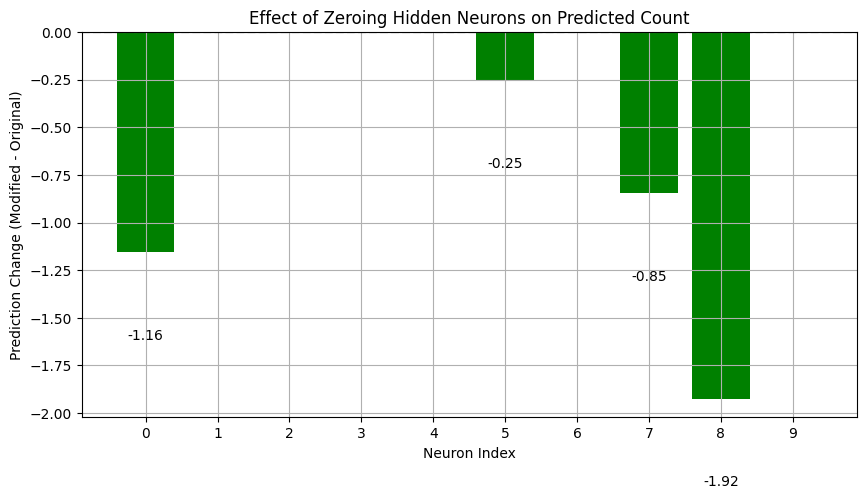

Neuron 0 → Prediction decreased by 1.16
Neuron 5 → Prediction decreased by 0.25
Neuron 7 → Prediction decreased by 0.85
Neuron 8 → Prediction decreased by 1.92


In [ ]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

print(f"🧾 True count: {true_count}, Baseline prediction: {baseline_pred:.2f}")

# Sweep: get signed change in scalar prediction
neuron_indices = list(range(model.fc1.out_features))
signed_deltas = []

for i in neuron_indices:
    with torch.no_grad():
        h = F.relu(model.fc1(test_input))
        h[:, i] = 0  # zero out neuron i
        mod_output = model.fc2(h)
        mod_pred = mod_output.item()
        signed_deltas.append(mod_pred - baseline_pred)

# Plotting signed prediction change per neuron
plt.figure(figsize=(10, 5))
colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

plt.bar(neuron_indices, signed_deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(neuron_indices)
plt.xlabel("Neuron Index")
plt.ylabel("Prediction Change (Modified - Original)")
plt.title("Effect of Zeroing Hidden Neurons on Predicted Count")
plt.grid(True)

# Annotatation
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        plt.text(i, d + (0.2 if d > 0 else -0.4), f"{d:+.2f}",
                 ha='center', va='bottom' if d > 0 else 'top')

plt.show()

# Summary
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        direction = "increased" if d > 0 else "decreased"
        print(f"Neuron {i} → Prediction {direction} by {abs(d):.2f}")


#### **What does the sweep of neuron ablations tell us?**

Which neurons had the most impact on predictions?

Are there redundant neurons (zeroing them causes no change)?

## Mechanistic case study: a "counting neuron"

In this tiny model, the input is an 8-bit binary vector and the target is the
number of 1s in that vector. The model is a small MLP with a single hidden
layer of 10 ReLU neurons and a scalar output.

After training the model, I inspected the hidden layer in several ways:

1. **Average activation heatmap.**  
   For each possible count (0–8) I averaged the hidden activations over all
   validation examples with that count. Plotting this as a heatmap (neurons on
   the y-axis, count on the x-axis) showed that some neurons have very clear
   monotonic patterns: they become more active as the number of 1s increases.

2. **Correlation with the true count.**  
   I then computed, for each neuron, the Pearson correlation between its
   activation and the true count across the whole validation set. One neuron
   (neuron *N*, where N is the index printed in the notebook) stood out with a
   correlation magnitude close to 1. This suggests that its activation is
   almost a linear function of “how many 1s are in the input”.

3. **Tuning curve of the neuron.**  
   For that neuron, I plotted its mean activation as a function of the number
   of 1s in the input. The curve is almost perfectly increasing and roughly
   linear: inputs with 0 or 1 ones have near-zero activation (because of the
   ReLU), and inputs with more 1s produce progressively larger activations.

4. **Incoming weights.**  
   I also printed the incoming weights from each of the 8 input bits into this
   neuron. The weights are all positive and fairly similar in magnitude, and
   the bias term is slightly negative. This means the pre-activation of the
   neuron is approximately:

   \[
   z \approx w \cdot \sum_i x_i + b
   \]

   where \(x_i \in \{0,1\}\). Because the ReLU clips negative values to zero,
   the neuron behaves like a **thresholded linear count** of the number of 1s.

5. **Ablation experiment.**  
   When I zero out this neuron’s activation while keeping all other neurons
   intact, the model’s predicted count decreases by about 1 on a range of test
   inputs. In contrast, zeroing some other neurons has almost no effect on the
   prediction. This shows that the model is actually *using* this neuron as a
   core feature for its decision, not just learning it passively.

**Mechanistic hypothesis**

Putting these observations together, my hypothesis is that neuron *N* is a
**“global counting feature.”** It roughly computes a linear approximation of
the number of 1s in the input (up to a ReLU threshold), and the final layer
uses this as a strong signal when predicting the output count. Other neurons
seem to provide finer-grained adjustments (for example, correcting small
systematic biases or specialising in particular ranges of counts), but this
single neuron carries a large fraction of the model’s “understanding” of the
task.

In other words, one specific hidden neuron has become an interpretable feature
that encodes “how many 1s are present,” which is exactly the high-level
concept the task requires.


## Reflection

**What I learned about how my model works**

Working through this exercise made it clear that even a very small MLP can
learn surprisingly interpretable internal features when the task is simple and
structured. In this case, at least one hidden neuron became a “counting
neuron” whose activation is almost a linear function of the number of 1s in
the input. The weight pattern (similar positive weights from each bit plus a
slightly negative bias) matches the intuitive computation we would have
designed by hand. The ablation experiments also showed that this neuron is
causally important: removing it reliably shifts the prediction downward.

**What was confusing or challenging**

One challenging part was distinguishing between neurons that look interesting
in plots (for example, they light up for certain counts) and neurons that are
actually *functionally necessary* for the model’s output. Some neurons have
moderate correlations with the count but ablating them barely changes the
prediction, which suggests redundancy or superposition with other units.
Another subtle point is that the model can get a good validation error even
when some individual neurons appear noisy or uninterpretable, so there is not
always a clean, human-readable story for every component.

**What I would like to understand or explore further**

If I had more time, I would like to:

- Track how these neurons evolve **during training** (e.g., save checkpoints
  and see when the counting neuron emerges).
- Try a slightly more complex task (like parity or sequence reversal) and see
  whether similarly clean features appear, or whether the representations
  become more entangled.
- Explore more systematic interventions, such as setting the counting neuron
  to different fixed values and measuring how the predicted count shifts across
  many inputs.

Overall, this assignment gave me a concrete, hands-on sense of what it means
to form a mechanistic hypothesis (“this neuron counts 1s”) and how to test it
using both visualisations and causal interventions.
